# Top 1000

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

CARBAMIDOMETHYL = cm = 57.021464
OXIDATION = ox = 15.994915
MOD_MAPPING = mm = {"C": str(cm), "M": str(ox)}

In [2]:
def barplot(labels, counts, colors, title, xlab = "Tool"):
    fig, ax = plt.subplots()
    ax.set_xlabel(xlab)
    ax.set_ylabel("Number of PSMs")
    ax.set_title(title)
    bars = ax.bar(labels, counts, color = colors)
    ax.bar_label(bars)
    return plt

In [3]:
def get_athena_peptidoform(amanda_row: pd.Series) -> str:
    seq = amanda_row["Annotated Sequence"]
    mods = amanda_row["Modifications"]
    if pd.isna(mods):
        return seq + "[]"
    mods = [str(mod).split("(")[0].strip() for mod in mods.split(";")]
    return f"{seq.upper()}[{'+'.join([str(int(mod[1:]) - 1) + ':' + mm[mod[0]] for mod in mods])}]"

In [4]:
ground_truth = pd.read_excel("amanda/PSMs_rep2_deconv_1%_percolator.xlsx")
ground_truth["Athena Sequence"] = ground_truth.apply(lambda row: get_athena_peptidoform(row), axis = 1)
athena_candidates = pd.read_csv("results/top1000_candidates.csv", sep = ";")
athena_psms = pd.read_csv("results/top1000_psms.csv", sep = ";")

In [5]:
len(ground_truth["First Scan"].unique().tolist())

14162

In [6]:
ground_truth_index = dict()
for i, row in ground_truth.iterrows():
    scan = int(row["First Scan"])
    psm = str(row["Athena Sequence"])
    if scan in ground_truth_index:
        ground_truth_index[scan].append(psm)
    else:
        ground_truth_index[scan] = [psm]

In [7]:
len(ground_truth_index)

14162

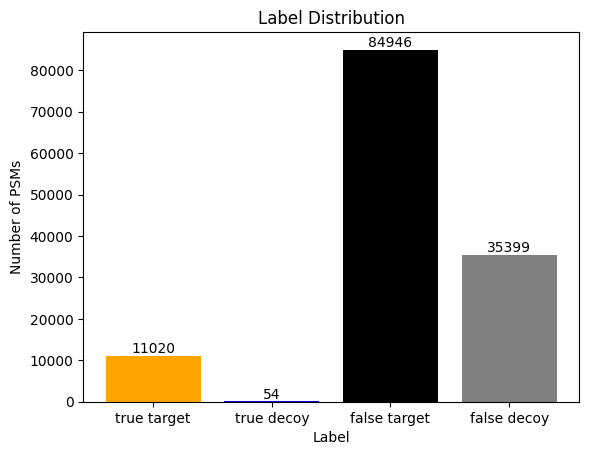

In [8]:
tt = athena_psms[athena_psms["Label"]=="true-target"].shape[0]
td = athena_psms[athena_psms["Label"]=="true-decoy"].shape[0]
ft = athena_psms[athena_psms["Label"]=="false-target"].shape[0]
fd = athena_psms[athena_psms["Label"]=="false-decoy"].shape[0]
barplot(["true target", "true decoy", "false target", "false decoy"], [tt, td, ft, fd], ["orange", "blue", "black", "grey"], "Label Distribution", "Label");

In [9]:
nr_psms = 0
nr_not_in_index = 0
nr_fp = 0
nr_tp = 0
ranks = [0, 0, 0, 0, 0]
for i, row in athena_psms[athena_psms["Label"]=="true-target"].iterrows():
    scan = int(row["ScanNumber"])
    psm = str(row["Peptidoform"])
    rank = int(row["Rank"])
    if scan in ground_truth_index:
        if psm in ground_truth_index[scan]:
            nr_tp += 1
            if rank >= 5:
                ranks[4] += 1
            else:
                ranks[rank - 1] += 1
        else:
            nr_fp += 1
    else:
        nr_not_in_index += 1
    nr_psms += 1

In [10]:
print(f"Total checked psms: {nr_psms}")
print(f"Total scans not in ground truth: {nr_not_in_index}")
print(f"Total FP: {nr_fp}")
print(f"Total TP: {nr_tp}")
print(f"FDR strict: {(nr_not_in_index + nr_fp) / nr_tp}")
print(f"FDR relaxed: {nr_fp / nr_tp}")

Total checked psms: 11020
Total scans not in ground truth: 292
Total FP: 116
Total TP: 10612
FDR strict: 0.038447041085563516
FDR relaxed: 0.010931021485111195


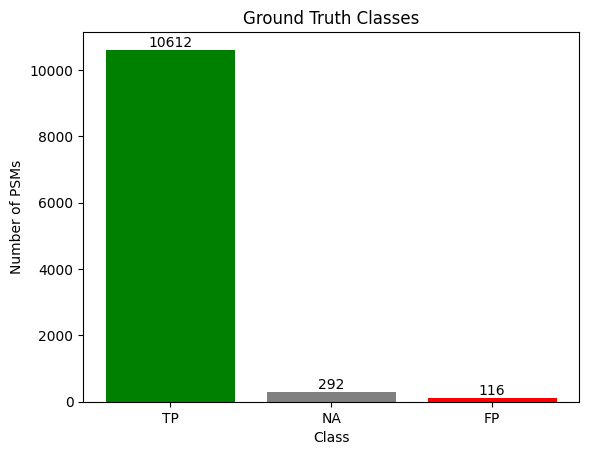

In [11]:
barplot(["TP", "NA", "FP"], [nr_tp, nr_not_in_index, nr_fp], ["green", "grey", "red"], "Ground Truth Classes", "Class");

In [12]:
print(ranks)

[7020, 1380, 1077, 433, 702]


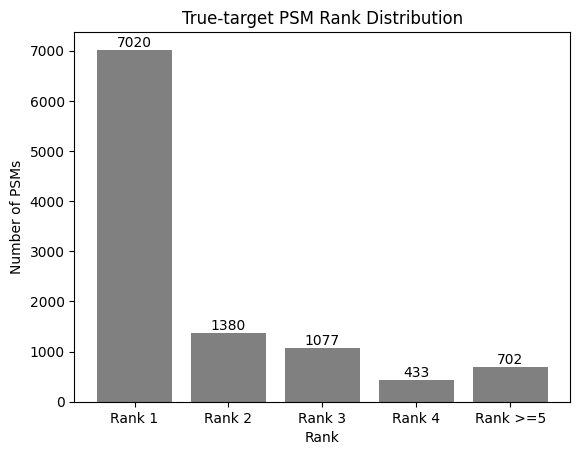

In [13]:
barplot(["Rank 1", "Rank 2", "Rank 3", "Rank 4", "Rank >=5"], ranks, ["grey" for x in range(5)], "True-target PSM Rank Distribution", "Rank");

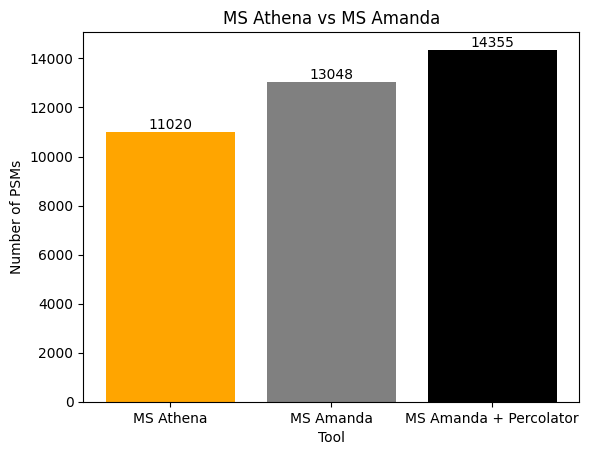

In [14]:
barplot(["MS Athena", "MS Amanda", "MS Amanda + Percolator"], [athena_psms[athena_psms["Label"]=="true-target"].shape[0], pd.read_excel("amanda/PSMs_rep2_deconv_1%.xlsx").shape[0], ground_truth.shape[0]], ["orange", "grey", "black"], "MS Athena vs MS Amanda");